- title: Practical Basic Hypothesis Tests
- tags: week6, statistics
- date: 2018-12-30

In this lesson, we're going to very quickly rip through the basic hypothesis tests, their uses, and how to achieve them in Python.  I won't spend a lot of time on this, because the mathematical details are covered in the assigned reading, and, at any rate, I think for practical purposes regression analysis is more important for lawyers.  Also, this is basically AP/undergrad stats material, so you've probably seen it somewhere already. 

Coverage: 

- Chi-square

- Fisher's exact test

- Binomial test

- T-test

- F-test/Anova

- Basic nonparametric t-test alternative (Wilcoxon/Mann Whitney)

There are lots of others, but this is the sort of standard menu of the basic stuff.  For guidelines of which to choose when, see [this page from UCLA](https://stats.idre.ucla.edu/other/mult-pkg/whatstat/).

## Chi-squared

- Use: test relationship between categorical variables, test whether two samples drawn from the same distribution. 

- Legal example: The population of registered voters/drivers license holders/etc. is X% women and Y% men; the jury pool is A% women and B% men. Should we believe that the potential jurors were selected from the whole population? P-value means how likely would we be to get the observed distribution from the underlying population.

- Basic idea: Take a crosstabulation (a.k.a. contingency table) of the sample, and calculate what the expected values of the cells in the table would be from the population.  See if they're crazy different.

Sticking with our jury example, suppose we had the following data on our underlying population and our jury pool: 

```
|                  | Women | Men  |
|------------------|-------|------|
| Not in Jury Pool | 4850  | 4650 |
| In Jury Pool     | 150   | 350  |
```


Here's how we'd do this in Python

In [1]:
from scipy.stats import chi2_contingency
import numpy as np

In [2]:
crosstab = np.array([[4850, 4650], [150, 350]])
chi2, p, dof, expected = chi2_contingency(crosstab)

In [3]:
p

6.802875042267758e-20

Further reading on chi-squared: 

- [Khan Academy](https://www.khanacademy.org/math/statistics-probability/inference-categorical-data-chi-square-tests)

- [Scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)

- [A lengthier tutorial in Python](https://machinelearningmastery.com/chi-squared-test-for-machine-learning/)

- [And another](https://towardsdatascience.com/running-chi-square-tests-in-python-with-die-roll-data-b9903817c51b) 

- [A nice article describing some of the assumptions of chi-squared in more detail](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900058/)

- [You should know that there are different versions of the chi-squared test, and know which one you're using---read the docs. This article explains the differences](http://inspire.stat.ucla.edu/unit_13/)

In our example, I might feel comfortable rejecting the null hypothesis that the jury pool came from the underlying population with a p-value that low. Or, same idea different phrasing, I might reject the null hypothesis that gender and being called to jury service are independent. 

But *maybe not*, because chi-squared is known to be sensitive to sample size---big samples can produce really big test statistics, and hence really small p-values, sort of arbitrarily.  So maybe we should think of a different test. 




## Fisher's exact test

Fisher's exact test is an alternative to the chi-squared that used to be a lot less popular before computational power went through the roof.  As the name suggests, it produces better estimates than chi-squared, but at the cost of computational complexity, so even today it's rarely used for big contingency tables (you could use chi-squared for a 4x4 table, a 9x9 table, etc.)  Traditionally, Fisher's exact test is used for small samples that are inappropriate for chi-squared. 

But it's never wrong to conduct an extra test!  (Well, it's wrong if you're doing research and you don't report them all.  We'll talk about this later.  Report every damn test you conduct.)  So let's try it on our big contingency table here.

In [4]:
from scipy.stats import fisher_exact

In [5]:
oddsratio, p = fisher_exact(crosstab)
print(p)

2.2248886823458282e-20


Also significant!  

Incidentally, that assigning two things to the result of a single function thing that we just did with `oddsratio, p = fisher_exact(crosstab)` is known as *tuple unpacking*.  the `fisher_exact` function actually returns a tuple `(oddsratio, pvalue)`, and we can just assign them to distinct variables all in one go.

Further reading on Fisher's exact test: 

- [Scipy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html)

- [A biostats person explains chi-squared, binomial, and Fisher tests](http://davidquigley.com/talks/2015/biostatistics/module_07.1.html#fishers-exact-test)



# Binomial test

Binomial tests are another count data test, basically the same as Fisher's test except that Fisher's test is based on the hypergeometric distribution, used for sampling without replacement, and the binomial test is based (surprise surprise!) on the binomial distribution, used for sampling with replacement.  

Binomial tests are used mainly to test for significant difference from a known binomial distribution.  For example, you'd use a binomial test to come to a conclusion about whether a coin is fair---coin flips are distributed according to a binomial distribution. 

An example legal application would be, perhaps, coming to a conclusion about the prosecution/defense bias of a single judge on granting defense motions to dismiss at the close of the prosecution's case. Given an assumed probability of granting motions to dismiss brought by the defense in the district (based on the observed proportion of same), how likely is it that our judge's motions to dimiss were generated by the same process that generated the district as a whole?  

In [6]:
from scipy.stats import binom_test

overall_district_grant_proportion = 0.2
our_judge_grant_count = 10
our_judge_total_motions_heard = 85

p = binom_test(our_judge_grant_count, our_judge_total_motions_heard, overall_district_grant_proportion)
print(p)

0.05792939694561368


So we probably wouldn't reject the null hypothesis that our judge's motion decisions are generated by a process with the same probability as the population as a whole. 

- [scipy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom_test.html)

## T-test

- Use: comparing two means (Sample mean to hypothesized mean, difference in means, etc. --- there are different flavors of the T test for these situations) from samples where you have all the data (not just frequencies), and you have interval data (that is, proper numbers, not just categories.  

- Basic idea: like the Z test (which is just a hypothesis test based on the normal distribution), but more robust to smaller sample sizes, where the central limit theorem doesn't give you quite as much confidence.  The T distribution has "fatter tails" than the normal distribution, so it'll give you higher p values for the same difference--- it's more conservative.  As sample size increases, the T distribution approaches the normal distribution.

- Legal example: suppose we think that African-Americans are being charged higher mortgage origination fees than whites.  We might collect a bunch of closing documents from the two groups and then run a t-test.  (Though note that this wouldn't be nearly enough to establish that actionable discrimination is happening, in part because we would need to control for other variables---wait till we get to the regression section.)

- Note that there are slightly different t-tests for independent data (i.e., two different groups of borrowers), and related or "paired" data (a common example given is student exam scores before and after some method of instruction, where each datapoint in the first sample is associated with a particular datapoint in the second).  There are actually [others as well](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/basic-statistics/inference/supporting-topics/tests-of-means/types-of-t-tests/), but those will serve for the most immediately useful ones.

    - in scipy.stats, the paired sample version is [ttest_rel](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html), and the independent sample version is [ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
    
To see an example here, we'll generate some fake data from normal distributions with different means.  (I'm too lazy to type it in.)  

I'm also going to use numpy's [random seed](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html) functionality. What this does is basically picks the point at which pseudo-random numbers are selected---it means that the random draws will still be random enough, but if you run the code from here on in, it'll be the same for you as well, you won't get different random numbers, and hence will get identical results.

In [7]:
np.random.seed(10)

fake_white_mean = 5000

fake_black_mean = 7000

shared_stdev = 2000

black_fees = np.random.normal(fake_black_mean, shared_stdev, 40)
white_fees = np.random.normal(fake_white_mean, shared_stdev, 40)

# round these samples to whole dollars to make it more realistic

black_fees = np.round(black_fees, 0)

white_fees = np.round(white_fees, 0)

# let's see what our fake data looks like

print(black_fees)
print(white_fees)

[ 9663.  8431.  3909.  6983.  8243.  5560.  7531.  7217.  7009.  6651.
  7866.  9406.  5070.  9057.  7457.  7890.  4727.  7270.  9969.  4840.
  3045.  3513.  7532. 11770.  9247. 10345.  7198.  9796.  6458.  8226.
  6465.  5901.  7265.  6048.  9617.  7390.  7800.  6325.  9513.  5536.]
[6320. 4298. 3121. 4021. 3391. 4575. 4322. 5624. 6130. 4705. 4948. 5578.
 3920. 6416. 6684. 5407. 9789. 6835. 4775. 4276. 4536. 3997. 7258. 3604.
 4838. 3941. 7092. 2163. 4275. 4756. 5639. 5922. 4568. 6978. 5630. 9935.
 1983. 6241. 2910. 3404.]


In [8]:
from scipy.stats import ttest_ind
t, p = ttest_ind(black_fees, white_fees)

In [9]:
print(p)

6.470058820542905e-07


We can very easily reject the null hypothesis that the means of the two groups are the same.  Which, obviously, since I generated the fake data from distributions that big different means.

Incidentally, I simulated data that would be expected to work particularly well with a T test: both populations had the same standard deviation (the `ttest_ind` function [gives you an option](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) to apply a standard correction if that's not true), and both were generated by a normal distribution. You should be careful with T tests if those aren't true, as you could get bogus results.  Also, these are all independent draws---if the data aren't independent, if, for example, the result the third white borrower gets depends in some way on what some other borrower got, then a T test is not appropriate.  

There are actually some controversial details about whether the underlying data needs to really be from a normal distribution for T tests, but there are nice nonparemetric alternatives (I'll explain what that means in a minute), so a good rule of thumb is that when data deviates too far from a normal distribution, just go with one of those instead.  (Unless you have a large sample. Then you'll be pretty ok in most cases.  Many people say "large" is over 30.)

Incidentally, a standard way to see whether or not your data deviates from a normal distribution is to produce what's known as a q-q plot, which plots your data against a theoretical distribution. Unsurprisingly, scipy provides a function [called probplot](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html) for this.  (Actually, there are technical quibbles about q-q plots vs probability plots, but, for practical purposes, what you want is a plot against a distribution and that's what you get here.)

((array([-2.11583547, -1.7314906 , -1.50271646, -1.33321868, -1.19520249,
         -1.07683093, -0.97189321, -0.87669641, -0.78885043, -0.70670905,
         -0.62908229, -0.55507545, -0.48399287, -0.41527745, -0.34847074,
         -0.28318561, -0.2190868 , -0.15587657, -0.09328369, -0.03105452,
          0.03105452,  0.09328369,  0.15587657,  0.2190868 ,  0.28318561,
          0.34847074,  0.41527745,  0.48399287,  0.55507545,  0.62908229,
          0.70670905,  0.78885043,  0.87669641,  0.97189321,  1.07683093,
          1.19520249,  1.33321868,  1.50271646,  1.7314906 ,  2.11583547]),
  array([ 3045.,  3513.,  3909.,  4727.,  4840.,  5070.,  5536.,  5560.,
          5901.,  6048.,  6325.,  6458.,  6465.,  6651.,  6983.,  7009.,
          7198.,  7217.,  7265.,  7270.,  7390.,  7457.,  7531.,  7532.,
          7800.,  7866.,  7890.,  8226.,  8243.,  8431.,  9057.,  9247.,
          9406.,  9513.,  9617.,  9663.,  9796.,  9969., 10345., 11770.])),
 (1996.350828526845, 7343.475, 0.99346

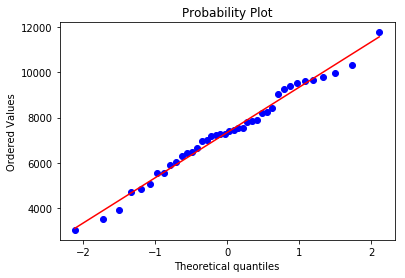

In [10]:
from scipy.stats import probplot
import matplotlib.pyplot as plt
%matplotlib inline


probplot(black_fees, dist="norm", plot=plt)


Unsurprisingly, this looks like it comes from a normal distribution.  Because, you know, it did. Now let's look at data that clearly isn't coming from a normal distribution.

((array([-2.11583547, -1.7314906 , -1.50271646, -1.33321868, -1.19520249,
         -1.07683093, -0.97189321, -0.87669641, -0.78885043, -0.70670905,
         -0.62908229, -0.55507545, -0.48399287, -0.41527745, -0.34847074,
         -0.28318561, -0.2190868 , -0.15587657, -0.09328369, -0.03105452,
          0.03105452,  0.09328369,  0.15587657,  0.2190868 ,  0.28318561,
          0.34847074,  0.41527745,  0.48399287,  0.55507545,  0.62908229,
          0.70670905,  0.78885043,  0.87669641,  0.97189321,  1.07683093,
          1.19520249,  1.33321868,  1.50271646,  1.7314906 ,  2.11583547]),
  array([3.85234168e-02, 5.31611196e-02, 6.86627128e-02, 7.30733709e-02,
         1.19669848e-01, 1.21156389e-01, 1.73185933e-01, 1.89334618e-01,
         2.17882621e-01, 2.25542495e-01, 2.80031702e-01, 4.14023103e-01,
         4.28020360e-01, 4.66862417e-01, 5.10154020e-01, 5.14481113e-01,
         5.40016698e-01, 5.75708801e-01, 7.88185254e-01, 8.67521072e-01,
         8.86028410e-01, 9.05241835e-01, 

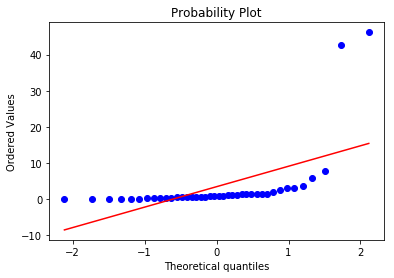

In [11]:
notnormal = np.random.pareto(1, 40)
probplot(notnormal, dist="norm", plot=plt)

There are tons of other ways to come to some conclusion about the necessary assumptions for t-tests--- scipy contains [tests for equal variances](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html), [for normality](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.shapiro.html), and so on and so on.  But, again, another solid solution is just to use a nonparametric test, which I'll talk about after talking about ANOVA and the F test.

Also, the minitab blog has two nice posts about understanding T tests: 

- [T Values and Distributions](http://blog.minitab.com/blog/adventures-in-statistics-2/understanding-t-tests-t-values-and-t-distributions)

- [Varieties of T Test](http://blog.minitab.com/blog/adventures-in-statistics-2/understanding-t-tests-1-sample-2-sample-and-paired-t-tests)

## F-Test/ANOVA

This (the one-way ANOVA, which follows the F distribution) is what you use to compare a bunch of means all at once. A significant p-value suggests that there's some difference between them, but doesn't tell you which one. Otherwise, it's basically the same (and rests on similar assumptions).  

For example, let's think about the current debates in college admissions, in which there's a claim that affirmative action discriminates against Asian-Americans. But also lots of white people claim that affirmative action discriminates again them, and ostensibly benefits other racialized groups.  One way we might take a first pass at figuring out if there's even a real difference is to compare whites, Asian-Americans, and everybody else.  (Again, this doesn't entail that there's discrimination, but it's a starting point.)

For our example here, I'm going to try something a little funky.  I'm going to generate a bunch of distributions of fake data, some of them are going to show a difference and some aren't, and then we'll try to detect which ones actually are different and see how accurate we are.

Our data will be SAT scores of admitted students to a hypothetical college, so the question will be: is there a difference among these groups in the average SAT score?  The [mean and SD SAT score are 1060 and 195, respectively](https://nces.ed.gov/programs/digest/d17/tables/dt17_226.40.asp), so we will start with that as out canonical distribution.  In order to limit ourselves to the actual range of SAT scores (400-1600), we'll use a scipy function to generate a truncated normal, which is actually kind of obnoxious to use, but such is life.

In [12]:
from scipy.stats import truncnorm, f_oneway

def make_dumb_truncation_params(mean):
    a = (400 - mean) / 195
    b = (1600 - mean) / 195
    return a, b

def generate_distribution():
    hasdiff = False
    results = {}
    sd = 195
    for group in ["white", "asian-american", "everybody-else"]:
        dieroll = np.random.uniform()
        if dieroll > 0.9:  # 10% chance of being different
            noise = np.random.uniform(0.7, 1.3)
            mean = 1060 * noise
            hasdiff = True
        else:
            mean = 1060
        a, b = make_dumb_truncation_params(mean)
        results[group] = np.round(truncnorm(a=a, b=b, loc=mean, scale=sd).rvs(500), 0)
    results["different"] = hasdiff
    return results

def test_significance(fake_data):
    w = fake_data["white"]
    aa = fake_data["asian-american"]
    ee = fake_data["everybody-else"]
    different = fake_data["different"]
    f, p = f_oneway(w, aa, ee)
    significant = p < 0.05
    if different == significant:
        print("correct result: difference is {} and I got a significant result t/f: {}".format(different, significant))
    else:
        print("INCORRECT result: difference is {} and I got a significant result t/f: {}".format(different, significant))
    
    
    

In [13]:
for x in range(30):
    test_significance(generate_distribution())

correct result: difference is False and I got a significant result t/f: False
correct result: difference is False and I got a significant result t/f: False
correct result: difference is False and I got a significant result t/f: False
correct result: difference is False and I got a significant result t/f: False
correct result: difference is True and I got a significant result t/f: True
correct result: difference is False and I got a significant result t/f: False
correct result: difference is True and I got a significant result t/f: True
correct result: difference is False and I got a significant result t/f: False
correct result: difference is False and I got a significant result t/f: False
correct result: difference is True and I got a significant result t/f: True
correct result: difference is False and I got a significant result t/f: False
correct result: difference is True and I got a significant result t/f: True
correct result: difference is False and I got a significant result t/f: 

We have a non-deterministic test.  Sometimes, data from the same distribution will look very different, sometimes data from different distributions will look the same.  But we did pretty well, two wrong out of 30!

There are other flavors of ANOVA too, but we won't worry about them here.

Further reading: 

- [scipy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html)

- another nice [minitab blog post](http://blog.minitab.com/blog/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test)

## Nonparametric alternatives to the T test

Finally, we'll look at some nonparametric alternatives to the T test.  *Nonparametric* means that some statistical tests don't require (or, as stats people say, "assume," but we really mean "require so you don't get the wrong answer") the underlying data fit any particular distribution (like normal).  

For paired data, we have the Wilcoxon signed rank test, provided by scipy.stats in [wilcoxon](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html)

For unpaired data, we have the Wilcoxon ranked sum test, provided by scipy.stats in [ranksum](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html), there is also the [Mann-Whitney U test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu) which is basically equivalent, and sometimes it's called the Wilcoxon-Mann-Whitney test. 

These tests are a little bit harder to understand---they aren't perfect substitutes for the T test, and, under some circumstances, it doesn't make sense to say that they're about equality of means.  (I've read some descriptions according to which the null hypothesis to be constructed is really about difference of medians, I've also seen references to difference in distributions more broadly.  So I won't say much more about it here, except to let you know that it exists, and that [this explanation from UVA](https://data.library.virginia.edu/the-wilcoxon-rank-sum-test/) looks pretty good.


<hr>
[Download this lesson in PDF]({attach}../images/basic_hypothesis_tests.pdf) [Download Jupyter Notebook file]({static}basic_hypothesis_tests.ipynb)
<hr>